## Exam I: CSCI4390-6390 (100 points)

This is a take-home exam. It is due 11:59:59pm on Monday, Oct 3 via submitty. You are expected to abide by the honor code, i.e., all work must be your own, and you are not allowed to discuss any aspect of exam with anyone except the TA or the professor. You are also not allowed to use the internet except to lookup numpy/python documentation, the book site, and class notes/videos. You must sign the declaration below that you will abide by the honor code.

#### **Honor Code Declaration**: Please sign with your name to acknowledge that you agree to abide by the honor code, and demonstrate the highest level of academic integrity.

Xinshi Wang

#### Download Dataset: Download the [Seeds Dataset](https://archive.ics.uci.edu/ml/datasets/seeds). It has 8 attributes, and 210 points. You need to ignore the last attribute, since it is the class variable, and we will not use it for our analysis. Store the dataset in your current directory and use "./seeds_dataset.txt" as its name. **DO NOT** submit the dataset as part of your answer on submitty.

In [40]:
import pandas as pd
import numpy as np
dataset = open('seeds_dataset.txt', 'r')
dataset_list = []
for line in dataset:
    data = line.strip().split('\t')
    while '' in data:
        data.remove('')
    assert(len(data) == 8)
    dataset_list.append([float(data[i]) for i in range(7)])
dataset = pd.DataFrame(data = np.array(dataset_list), columns=range(7))

In [41]:
## helper functions
def length(a):
    return np.sqrt(np.dot(a.T,a))
def normalize(a):
    return a/length(a)
def get_cov(X,X_mean):
    return (np.dot((X-X_mean).T,(X-X_mean))/X.shape[0])
def get_mean(X):
    return X.sum(axis=0) / X.shape[0]
def total_variance(X,X_mean):
    return np.sum((X-X_mean)**2) / X.shape[0]
def project_data(eigen_vectors,centered_kernel):
    basis = np.column_stack([eigen_vectors[:, 1-i]
                           for i in range(2)])    
    projection = np.dot(basis.T,centered_kernel)
    return projection

#### Q1. (20 points) Find the first two eigenvectors and eigenvalues using power-iteration. First set np.random.seed(42), and use np.random.random_sample to generate the random vectors. Set eps=1e-6 for convergence testing.

In [50]:
np.random.seed(42)
A = dataset.to_numpy()
A = A - get_mean(A)
## find out what is d
d = A.shape[1]
epsilon = 10e-6
intermediate_result = list()
X_i = np.random.random_sample([d,2])
X_i[:,0] = normalize(X_i[:,0])
X_i[:,1] = normalize(X_i[:,1])
cov = get_cov(A,get_mean(A))
while len(intermediate_result)<2 or np.linalg.norm(intermediate_result[-1] - intermediate_result[-2])>=epsilon:
    X_iplus1 = np.dot(cov,X_i)
    X_iplus1[:,1] = X_iplus1[:,1] - np.dot((np.dot(X_iplus1[:,1].T,X_iplus1[:,0])/np.dot(X_iplus1[:,0].T,X_iplus1[:,0])),X_iplus1[:,0])
    X_iplus1[:,0] = normalize(X_iplus1[:,0])
    X_iplus1[:,1] = normalize(X_iplus1[:,1])
    X_i = X_iplus1
    intermediate_result.append(X_iplus1)
u_1 = X_iplus1[:,0]
u_2 = X_iplus1[:,1]
labda_1 = np.dot(np.dot(u_1.T,cov.T),u_1)/(np.dot(u_1.T,u_1))
labda_2 = np.dot(np.dot(u_2.T,cov.T),u_2)/(np.dot(u_2.T,u_2))

In [52]:
print(f'The first eigenvector is {u_1} and the corresponding eigenvalue is {labda_1}. The second eigenvector is {u_2} and the corresponding eigenvalue is {labda_2}')

The first eigenvector is [ 0.88422855  0.39540544  0.00431132  0.12854449  0.11105914 -0.12761514
  0.12896654] and the corresponding eigenvalue is 10.74193012480951. The second eigenvector is [ 0.10080534  0.05648943 -0.00289475  0.03062167  0.00237224  0.98941054
  0.08223333] and the corresponding eigenvalue is 2.119314853837908


#### Q2. (10 points) Plot the two eigenvectors: Plot the original (uncentered) data using the first two original dimensions, and then show the projection of the two eigenvectors on that original 2D subspace. Use red for the 1st PC, and blue for 2nd PC. What do you observe. Explain.

[Text(0.5, 1.0, 'original data using the first 2 dimensions')]

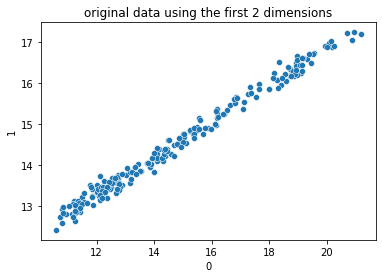

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(x=0, y=1, data=dataset).set(title = "original data using the first 2 dimensions")

# The first PC corresponds to the direction of maximum variance. The second corresponds to tbhe second maximum variance

#### Q3. (**CSCI6390 Only**: 10 points) PC as Linear Combination: Since all directions are linear combinations of the points, express the first eigenvector as a linear combinations of the original data points. That is, compute the point-wise weights, and print out the weight vector as a histogram with bins=100. Also print the weights for the first 10 points.

#### Q4. (20 points) Kernel PCA: Using the homogeneous quadratic kernel,  find the kernel PCs. How many dimensions does it take so that fraction of  approximation error does not exceed 0.001? Plot the points onto the first two kernel PCs.

In [69]:
def generate_kernel(dataset,kernel,spread = None):
    empty_kernel = np.zeros((dataset.shape[0],dataset.shape[0]))
    for i in range(dataset.shape[0]):
        for j in range(i,dataset.shape[0]):
            X = dataset[i,:]
            Y = dataset[j,:]
            if kernel == 'quadratic':
                K_ij = compute_quadratic_kernel(X,Y)
            empty_kernel[i][j] = K_ij
            empty_kernel[j][i] = K_ij
    return  empty_kernel

def compute_quadratic_kernel(X,Y):
    return np.dot(X.T,Y)**2   
      
def center_kernel(kernel):
    coeffs = np.eye(kernel.shape[0]) - (1/(kernel.shape[0])*np.ones((kernel.shape[0],kernel.shape[1])))
    centered_kernel = np.dot(np.dot(coeffs,kernel),coeffs)
    return centered_kernel

def compute_eigens(centered_kernel):
    eigen_values,eigen_vectors = np.linalg.eigh(centered_kernel)
    eigen_values = eigen_values[::-1]
    eigen_vectors = eigen_vectors[:, ::-1]
    return eigen_values, eigen_vectors

def compute_variance(eigen_values,n):
    variance = []
    for i in eigen_values:
        variance.append(i/n)
    return variance

def normalize_eigen_vectors(eigen_vectors,eigen_values):
    for i in range(len(eigen_values)):
        eigen_vectors[:,i] = np.sqrt(1/abs(eigen_values[i]))*eigen_vectors[:,i]
    return eigen_vectors

def fraction_of_total_variance(variance,n):
    total_var = sum(variance)
    var_to_n = sum(variance[:n])
    return var_to_n/total_var

def project_data(eigen_vectors,centered_kernel):
    basis = np.column_stack([eigen_vectors[:, 1-i]
                           for i in range(2)])    
    projection = np.dot(basis.T,centered_kernel)
    return projection

In [76]:
dataset = np.array(dataset)
quadratic_kernel = generate_kernel(dataset,'quadratic')
centered_kernel = center_kernel(quadratic_kernel)
eigen_values,eigen_vectors = compute_eigens(centered_kernel)
variance = compute_variance(eigen_values,quadratic_kernel.shape[0])
eigen_vectors = normalize_eigen_vectors(eigen_vectors,eigen_values)
fraction_of_total_variance(variance,5)>1-0.001

True

# It takes 5 dimensions

[Text(0.5, 1.0, 'projection onto the first 2 kernel principal components')]

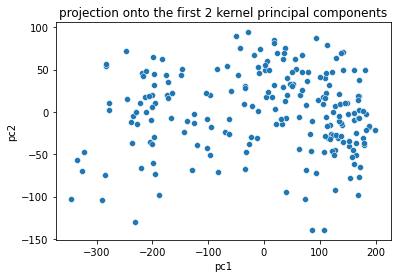

In [251]:
projection = pd.DataFrame(project_data(eigen_vectors,centered_kernel).T,columns=['pc2','pc1'])
sns.scatterplot(data = projection, x= 'pc1',y = 'pc2').set(title = "projection onto the first 2 kernel principal components")

#### Q5 (20 points) Non-linear direction in input space: For the polynomial kernel it is actually possible to compute the direction of the kernel principal component. For the homogeneous quadratic kernel, compute the best quadratic PC direction equation.

In [300]:
# the best quadratic PC is the first pc
best = eigen_vectors[0]
x_1 = dataset[:,0][0]
x_2 = dataset[:,1][0]
x_3 = dataset[:,2][0]
x_4 = dataset[:,3][0]
x_5 = dataset[:,4][0]
x_6 = dataset[:,5][0]
x_7 = dataset[:,6][0]
#we can reverse engineering from the back to figure out the best p
def assignment(n,results):
    pass

NameError: name 'p1' is not defined

#### Q6. (20 points) Points in high dimensional spheres: Generate $n=10,000$ points in a $d$-dimensional hypersphere with radius $r=1+\epsilon$, where $\epsilon=0.1$ is some small value. Plot the fraction of the points that lie within the unit hypersphere for various values of $d$ from $d=2$ to $d=30$. Explain the findings. Follow the steps below to generate the points, and make sure to plot them in 2D and 3D.

To generate points uniformly in a $d$-dimensional hypersphere with radius $r$, first set np.random.seed(42), and then do the following: First draw a random sample $Y$ from the standard multivariate normal distribution in $d$ dimensions (use np.random.multivariate_normal). Next, normalize $Y$ to get $S = Y / ||Y||$ (which can be shown to have a uniform distribution on the unit $d$-sphere). Next, multiply $S$ by $U^{1/d}$, that is, the $d$-th root of $U$, where $U$ is a random sample drawn from the uniform distribution on the unit interval $[0,1)$ (use np.random.uniform). This can be shown to create a uniform distribution of $d$-dimensional points within the unit $d$-dimensional hyperball. **Show the plot of the random points in 2D and 3D balls**. Make sure the points are uniformly distributed.

[Text(0.5, 1.0, 'random points in 2D balls')]

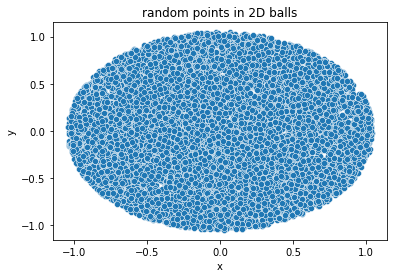

In [148]:
Y = np.random.multivariate_normal(np.zeros(2), np.eye(2),size=10000)
U = np.random.uniform(low=0,high=1,size=10000)
for i in range(Y.shape[0]):
    Y[i,:] = normalize(Y[i,:])*((1+epsilon)*U[i])**(1/2)
Y = pd.DataFrame(Y,columns=['x','y'])
sns.scatterplot(data = Y, x= 'x',y = 'y').set(title = "random points in 2D balls")


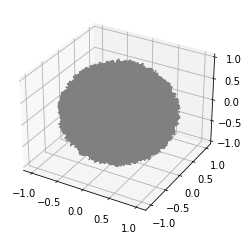

In [149]:
Y = np.random.multivariate_normal(np.zeros(3), np.eye(3),size=10000)
U = np.random.uniform(low=0,high=1,size=10000)
for i in range(Y.shape[0]):
    Y[i,:] = normalize(Y[i,:])*((1+epsilon)*U[i])**(1/3)
Y = pd.DataFrame(Y,columns=['x','y','z'])
ax = plt.axes(projection='3d')
ax.plot3D(Y.x, Y.y, Y.z, 'gray')

<AxesSubplot:xlabel='d', ylabel='fraction'>

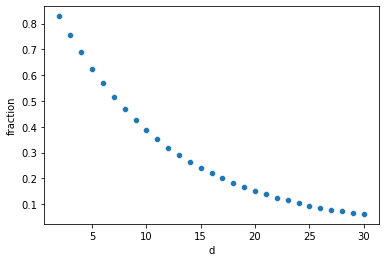

In [189]:
epsilon = 0.1
ds = []
U = np.random.uniform(low=0,high=1,size=10000)
for d in range(2,31):
    Y = np.random.multivariate_normal(np.zeros(d), np.eye(d),size=10000)
    for i in range(Y.shape[0]):
        Y[i,:] = normalize(Y[i,:])*((1+epsilon)*U[i]**(1/d))
    ds.append(Y)
# if a point has norm<=1+epsilon, then it is in the inscribed hypersphere
ds_counter = [0]*len(ds)
for i in range(len(ds)):
    for j in range(ds[i].shape[0]):
        if length(ds[i][j,:]) <= 1:
            ds_counter[i] += 1
    ds_counter[i] = ds_counter[i]/(ds[i].shape[0])
ds_counter_1 = np.concatenate((np.array(range(2,31)).reshape(-1,1),np.array(ds_counter).reshape(-1,1)),axis = 1)
ds_counter_1 = pd.DataFrame(ds_counter_1,columns=['d','fraction'])
sns.scatterplot(data = ds_counter_1, x= 'd',y = 'fraction')

# The fraction is decaying exponentially. Thus the higher the dimension, the smaller the volume of the unit sphere is.

#### Q7. (10 points) Prove or Disprove: $\bar{X}^T Y = \bar{X}^T \bar{Y}$. Here $X$ and $Y$ are two attribute vectors, and $\bar{X}$ and $\bar{Y}$ are their centered counterparts.

(You may type your answer in latex via markdown, i.e., enclose math with '$' signs, or you may attach a figure. To attach a figure, just drag and drop an image in the "markdown" cell below.)

In [282]:
y = np.random.uniform(low = 50, high = 100, size =10)
x = np.random.uniform(low = 50, high = 100, size =10)
x = x - x.mean()
np.dot(x.T,y)

146.82226976109126

In [283]:
print(y.mean())
y = y - y.mean()
np.dot(x.T,y)

76.78504191413889


146.82226976109462

![image info](img.jpg)

#### Q8 (**CSCI 6390 Only**: 10 points) Let $\mathbf{a}$ be random $d$-dimensional binary vector, and $\mathbf{b}$ a random $d$-dimensional corner in a $d$-dimensional unit hypercube (with the range in each axis as $[0,1]$). Derive the formula for the expected angle between $\mathbf{a}$ and $\mathbf{b}$? 